# NER USING CRF

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

 The IOB Tagging system contains tags of the form:
* **B** - {CHUNK_TYPE} – for the word in the Beginning chunk
* **I** - {CHUNK_TYPE} – for words Inside the chunk
* **O** – Outside any chunk

The IOB tags are further classified into the following classes –
* **geo** = Geographical Entity
* **org** = Organization
* **per** = Person
* **gpe** = Geopolitical Entity
* **tim** = Time indicator
* **art** = Artifact
* **eve** = Event
* **nat** = Natural Phenomenon

[Penn Treebank tagset](https://www.sketchengine.eu/tagsets/penn-treebank-tagset/#:~:text=The%20English%20Penn%20Treebank%20tagset,Sketch%20Engine%20(earlier%20version).)

> [reference link](https://www.kaggle.com/shoumikgoswami/ner-using-random-forest-and-crf)

> Libraries

In [1]:
#Data analysis
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
# from sklearn_crfsuite import CRF, scorers, metrics
# import sklearn_crfsuite
# from sklearn_crfsuite import scorers
# from sklearn_crfsuite import metrics
# from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy.stats
import eli5

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('/kaggle/input/crftrain101/train_generic.csv', encoding="latin1")

In [3]:
# df = df.rename(columns={"Sentence #": "sentence#"})

In [4]:
df.head()

,sentence_id,word,tag
0,0,à¦¤à¦¾à¦°,O
1,0,à¦®à§à¦¤à§à¦¯à§à¦°,O
2,0,à¦¦à¦¶,O
3,0,à¦¦à¦¿à¦¨,O
4,0,"à¦ªà¦°,",O


In [5]:
df.shape

(191897, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191897 entries, 0 to 191896
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   sentence_id  191897 non-null  int64 
 1   word         191897 non-null  object
 2   tag          191897 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.4+ MB


In [8]:
#so we are basically having only those rows where sentence column is not null
data = df[df['sentence_id'].notnull()]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191897 entries, 0 to 191896
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   sentence_id  191897 non-null  int64 
 1   word         191897 non-null  object
 2   tag          191897 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.9+ MB


## Exploring / Visualizing our data

Before going further, we will try to understand what the dataset is all about and what all the features mean. This is important in order to understand how the classifiers will perform and help us interpret the results.

In [10]:
data.head()

,sentence_id,word,tag
0,0,à¦¤à¦¾à¦°,O
1,0,à¦®à§à¦¤à§à¦¯à§à¦°,O
2,0,à¦¦à¦¶,O
3,0,à¦¦à¦¿à¦¨,O
4,0,"à¦ªà¦°,",O


The dataset has the following columns or features -

* **Index -** Index numbers for each word [Numeric type]
* **Sentence #** - The number of sentences in the dataset (We will find the number of sentences below) [Numeric type]
* **Word -** The words in the sentence [Character type]
* **POS -** Parts Of Speech tags, these are tags given to the type of words as per the Penn TreeBank Tagset [Categorical type]
* **Tag -**The tags given to each word based on the IOB tagging system described above (Target variable) [Categorical type]

In [17]:
# A class to retrieve the sentences from the dataset
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [18]:
getter = getsentence(data)

In [19]:
sentences = getter.sentences
#ths is how a sentence will look like.
print(sentences[1])

[('à¦¬à§\x8dà¦°à¦¾à¦\x82à¦®à§\x8dà¦¯à¦¾à¦¨', 'O'), ('à¦¡à¦¾à¦®à§\x8dà¦ªà¦¸à¦¨', 'O'), ('à§§à§ªà§¦à§¦', 'O'), ('à¦¸à¦¾à¦²à§\x87', 'O'), ('à¦\x86à¦¨à§\x8dà¦¤à¦°à§\x8dà¦\x9cà¦¾à¦¤à¦¿à¦\x95', 'B-GRP'), ('à¦°à§\x87à¦¡', 'I-GRP'), ('à¦\x95à§\x8dà¦°à¦¸', 'I-GRP'), ('à¦\x93', 'I-GRP'), ('à¦°à§\x87à¦¡', 'I-GRP'), ('à¦\x95à§\x8dà¦°à¦¿à¦¸à§\x87à¦¨à§\x8dà¦\x9f', 'I-GRP'), ('à¦\x86à¦¨à§\x8dà¦¦à§\x8bà¦²à¦¨', 'I-GRP'), ('à¦\x8fà¦°', 'O'), ('à¦¸à§\x8dà¦¬à§\x87à¦\x9aà§\x8dà¦\x9bà¦¾à¦¸à§\x87à¦¬à¦\x95', 'O'), ('à¦¹à¦¿à¦¸à§\x87à¦¬à§\x87', 'O'), ('à¦¶à§\x81à¦°à§\x81', 'O'), ('à¦\x95à¦°à§\x87à¦\x9bà¦¿à¦²à§\x87à¦¨à¥¤', 'O')]


In [20]:
#Lets find the number of words in the dataset
words = list(set(data["word"].values))
n_words = len(words)
print(n_words)

33185


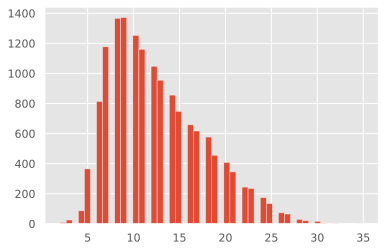

In [21]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

so this is dataset is for learning purpose there we are having a same length of sentence

In [22]:
#Lets find out the longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 35


Now that we know the words and sentences, lets try to understand what sort of words each tag contains. This will help us in understanding what each tag type and sub-type represents.

In [23]:
#Words tagged as B-per
data.loc[data['tag'] == 'B-per', 'word'].head()

Series([], Name: word, dtype: object)

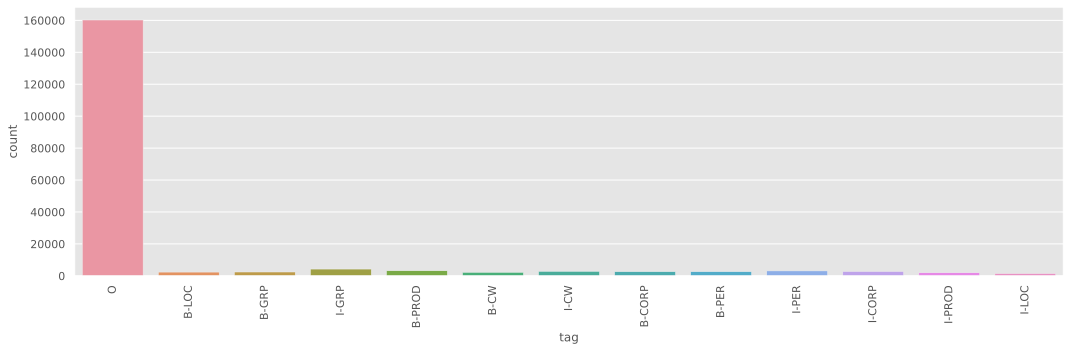

In [24]:
#Words distribution across Tags
plt.figure(figsize=(15, 5))
ax = sns.countplot('tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

Quite surprising, most of the words are tagged as outside of any chunk. These words can be considered as fillers and their presence might impact the classifier performance as well. Lets check the dataset again without the O tags.

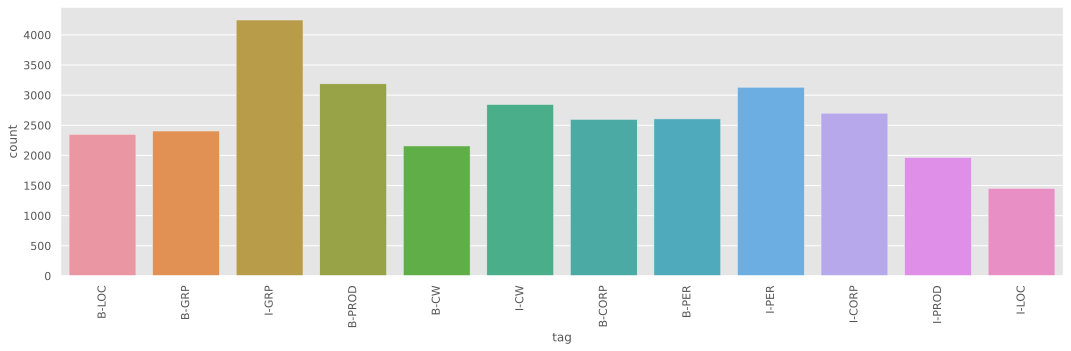

In [25]:
#Words distribution across Tags without O tag
plt.figure(figsize=(15, 5))
ax = sns.countplot('tag', data=data.loc[data['tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

> So our dataset mostly contains words related to `geopolitical entities`, `geographical locations` and `person names`.

## **Modeling the Data**

With the basic EDA done and understanding the dataset, we can move to the modeling stage.
Since the problem statement is a simple classification problem, we will start with a simple tree based model, Random Forest using a simple feature map.
Simple tree based models have been proven to provide decent performance in building NERC systems. Random Forest being one of the most popular tree based models can learn the underlying rules according to which terms are tagged. It is important that the classifier has proper features fed in to improve the performance.

Performance metrics
Before we move to the modeling part, it is important to understand the performance metrics on the basis of which the models will be evaluated. Since we are dealing with Information Extraction, we will use the following metrics to evaluate the models -

* Precision
* Recall
* F1 score

The metrics mentioned above are calculated using True/False positives and True/False negatives respectively.
* True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.
* True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.
* False Positives (FP) – When actual class is no and predicted class is yes.
* False Negatives (FN) – When actual class is yes but predicted class in no.
* Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.

Precision=TP/TP+FP 

* Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes.

Recall=TP/TP+FN 

* F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is the harmonic mean of the both Precision and Recall

F1−Score=2∗(Recall∗Precision)/(Recall+Precision) 

For a decent classifier, we would prefer high precision and recall values. Classification reports are used to obtain the values of these metrics in a text format per class. It is essential that the model is evaluated by these metrics per class to make sure we have a good model.

### Random Forest Classifier

In [27]:
#Simple feature map to feed arrays into the classifier. 
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

In [28]:
#We divide the dataset into train and test sets
words = [feature_map(w) for w in data["word"].values.tolist()]
tags = data["tag"].values.tolist()

In [29]:
#Lets see how the input array looks like
print(words[:5])

[array([0, 1, 0, 9, 0, 0]), array([ 0,  1,  0, 21,  0,  0]), array([0, 1, 0, 6, 0, 0]), array([0, 1, 0, 9, 0, 0]), array([0, 1, 0, 7, 0, 0])]


We will use 5 fold cross validation as an input parameter to the classifier, i.e. we will divide the dataset into 5 subsets and train-test on them. Some models like decision trees and neural networks are often be able to get 100% accuracy on the training data, but perform much worse on new data. Therefore, we will train on one subset and test on the other, and repeat for every subset so that the classifier classifies correctly on average and the performance estimate is not overly optimistic

In [30]:
#Random Forest classifier
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words, y=tags, cv=5)

In [31]:
#Lets check the performance 
from sklearn.metrics import classification_report
report = classification_report(y_pred=pred, y_true=tags)
print(report)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      B-CORP       0.00      0.00      0.00      2598
        B-CW       0.12      0.00      0.00      2157
       B-GRP       1.00      0.00      0.00      2405
       B-LOC       0.41      0.00      0.01      2351
       B-PER       0.00      0.00      0.00      2606
      B-PROD       0.50      0.00      0.00      3188
      I-CORP       0.00      0.00      0.00      2701
        I-CW       0.43      0.00      0.00      2844
       I-GRP       0.00      0.00      0.00      4248
       I-LOC       0.20      0.00      0.00      1453
       I-PER       0.14      0.00      0.00      3132
      I-PROD       0.33      0.00      0.00      1964
           O       0.84      1.00      0.91    160250

    accuracy                           0.84    191897
   macro avg       0.31      0.08      0.07    191897
weighted avg       0.74      0.84      0.76    191897



Although we have a good average score, the model performed quite badly. The precision and recall values of most of the classes were 0. It seems the features which require the model to take proper decisions are missing. The model is basically memorizing words and tags, which will not suffice. The context information behind each word needs to be fed to the model as well so that the predictions are more accurate.
We can either work on this model alone by improving the features or ensembling it with a more contextual model, or use a different model altogether.

### Conditional Random Fields classifier

A Conditional Random Field (CRF) is a standard model for predicting the most likely sequence of labels that correspond to a sequence of inputs. It is a supervised learning method which has been proven to be better than the tree based models when it comes to NER. Whereas a discrete classifier predicts a label for a single sample without considering "neighboring" samples, a CRF can take context into account; e.g., the linear chain CRF (which is popular in natural language processing) predicts sequences of labels for sequences of input samples.

In order to use CRF, we will enhance the feature set and create more features which can be used by the model to predict the tags correctly. Since we need to take into account the context as well, we create features which will provide consecutive POS tags for each word. Also, we add new features such as upper, lower, digit, title etc. for each word and also consider the consecutive words in the list. In short, we try to provide a sequence of features to the model for each word - the sequence containing POS tags, capitalisations, type of word(title) etc.

In [32]:
!pip install sklearn-crfsuite

     |████████████████████████████████| 965 kB 287 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [33]:
from itertools import chain

import nltk
import sklearn
import scipy.stats

import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics

In [34]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [37]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token,label in sent]

In [38]:
#Creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [39]:
#Creating the CRF model
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [40]:
#We predcit using the same 5 fold cross validation
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [41]:
#Lets evaluate the mode
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

      B-CORP       1.00      1.00      1.00      2598
        B-CW       1.00      1.00      1.00      2157
       B-GRP       1.00      1.00      1.00      2405
       B-LOC       1.00      1.00      1.00      2351
       B-PER       1.00      1.00      1.00      2606
      B-PROD       1.00      1.00      1.00      3188
      I-CORP       1.00      1.00      1.00      2701
        I-CW       1.00      1.00      1.00      2844
       I-GRP       1.00      1.00      1.00      4248
       I-LOC       1.00      1.00      1.00      1453
       I-PER       1.00      1.00      1.00      3132
      I-PROD       1.00      1.00      1.00      1964
           O       1.00      1.00      1.00    160250

    accuracy                           1.00    191897
   macro avg       1.00      1.00      1.00    191897
weighted avg       1.00      1.00      1.00    191897



Compared to the Random Forest classifier, the CRF classifier did better as the scores have improved. 
However, the precision and recall metrics of the classes individually have improved but not much. Maybe the model is again remembering words and not taking into the context information completely. We will try tuning the model manually to see if we can improve it.

In [42]:
crf2 = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=200,
    c2=0.1,
    max_iterations=20,
    all_possible_transitions=False,
)
crf2.fit(X, y)


CRF(algorithm='lbfgs', all_possible_transitions=False, c1=200, c2=0.1,
    keep_tempfiles=None, max_iterations=20)

In [43]:
# eli5.show_weights(crf2, top=30)

In [45]:
df2 = pd.read_csv('/kaggle/input/crftrain101/dev_generic.csv', encoding="latin1")
data2 = df2[df2['sentence_id'].notnull()]
getter2 = getsentence(data2)
sentences2 = getter2.sentences

In [46]:
#Creating =test set
X_test = [sent2features(s) for s in sentences2]
y_test = [sent2labels(s) for s in sentences2]

In [47]:
len(X_test)

800

In [48]:
len(y_test)

800

In [49]:
pred2 = crf2.predict(X_test)

In [50]:
report = flat_classification_report(y_true=y_test, y_pred=pred2)

In [51]:
print(report)

              precision    recall  f1-score   support

      B-CORP       1.00      1.00      1.00       127
        B-CW       1.00      1.00      1.00       120
       B-GRP       1.00      1.00      1.00       118
       B-LOC       1.00      1.00      1.00       101
       B-PER       1.00      1.00      1.00       144
      B-PROD       1.00      1.00      1.00       190
      I-CORP       1.00      1.00      1.00       122
        I-CW       1.00      1.00      1.00       161
       I-GRP       1.00      1.00      1.00       226
       I-LOC       1.00      1.00      1.00        61
       I-PER       1.00      1.00      1.00       180
      I-PROD       1.00      1.00      1.00       129
           O       1.00      1.00      1.00      8654

    accuracy                           1.00     10333
   macro avg       1.00      1.00      1.00     10333
weighted avg       1.00      1.00      1.00     10333



Future Scope - we can do the hyperparameter tuning